<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Полный-датасет-(без-разделения)---CatBoost" data-toc-modified-id="Полный-датасет-(без-разделения)---CatBoost-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Полный датасет (без разделения) - CatBoost</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Загрузка-и-обработка-данных" data-toc-modified-id="Загрузка-и-обработка-данных-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Загрузка и обработка данных</a></span></li><li><span><a href="#Custom-функции-для-Cross-validation-и-WAPE" data-toc-modified-id="Custom-функции-для-Cross-validation-и-WAPE-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Custom функции для Cross validation и WAPE</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Проверка-на-тестовых-данных" data-toc-modified-id="Проверка-на-тестовых-данных-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>Проверка на тестовых данных</a></span></li></ul></li></ul></li></ul></div>

# Построение моделей

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
sns.set_palette("pastel")

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import make_scorer
import catboost as cb
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score

import json
import warnings

___

## Полный датасет (без разделения) - CatBoost

#### Загрузка и обработка данных

Загрузим полный датасет (сохранили в notebook с EDA)

In [2]:
#загрузка полного датасета и словаря с индексами для CV
data_full = pd.read_csv('data_full.csv')
data_full_dates = pd.read_csv('data_full_dates.csv')
data_submission = pd.read_csv('data_submission.csv')
data_test_dates = pd.read_csv('data_test_dates.csv')


# Opening JSON file
with open('data_full_dict.json') as json_file:
    data_full_cv = json.load(json_file)
json_file.close()

Выделим train данные

In [3]:
X_train = data_full.drop(columns=['target'])
y_train = data_full['target']

Выделим фичи категориальные и числовые (категориальные далее понадобятся для Catboost)

In [4]:
%%capture

#create an instance of scaling and encoding the features

#data transformation objects
#using OE (not OHE) for tree-like models (incl boosting) because two much unuique values -> 
#to many transformed columns -> longer time and OHE for linear regression
# sc = StandardScaler()
# oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# ohe = OneHotEncoder(handle_unknown='ignore')

#list of numeric and non-numeric features
    #days_ny, days_paskha - not encoding      

features_n = ['day',
            'dayofweek',
            'ma_3d',
            'ma_6d',
            'ma_9d',
            'ma_12d',
            'ma_15d',
            'max_3d',
            'max_6d',
            'max_9d',
            'max_12d',
            'max_15d',
            'min_3d',
            'min_6d',
            'min_9d',
            'min_12d',
            'min_15d',
            'sales_0days_ago',
            'sales_1days_ago',
             'sales_2days_ago',
             'sales_3days_ago',
             'sales_4days_ago',
             'sales_5days_ago',
             'sales_6days_ago',
             'sales_7days_ago',
             'sales_8days_ago',
             'sales_9days_ago',
             'sales_10days_ago',
             'sales_11days_ago',
             'sales_12days_ago',
             'sales_13days_ago',
             'sales_14days_ago',
             'sales_15days_ago',
             'sales_16days_ago',
             'sales_17days_ago',
             'sales_18days_ago',
             'sales_19days_ago',
             'sales_20days_ago',
             'sales_21days_ago']

features_str = ['st_id',
                'pr_sku_id',
                'st_city_id',
                'st_division_code',
                'st_type_format_id',
                'st_type_loc_id',
                'st_type_size_id',
                'pr_group_id',
                'pr_cat_id',
                'pr_subcat_id',
                'pr_uom_id',
                'holiday',
               ]

#change all categorical to string
for col in X_train[features_str].columns:
    X_train[col] = X_train[col].astype(str)

# #combine into one single object
# ct_oe = make_column_transformer(
#     (sc, features_n),
#     (oe, features_str),
#     remainder='passthrough'
# )

# #combine into one single object
# ct_ohe = make_column_transformer(
#     (sc, features_n),
#     (ohe, features_str),
#     remainder='passthrough'
# )


#fit the transformers
# ct_oe.fit(X_train)
# ct_ohe.fit(data_full)

#### Custom функции для Cross validation и WAPE

Создадим custom cross validation для Catboost: три итерации выбора по 14 дней для прогноза в качестве валидационных данных.

Объект валидации генерирует индексы для выбора данных из полного датасета (на основании дат). Индексы были получены при сохранении файлов после препроцессинга в книге EDA and Preprocessing

In [5]:
class CustomCrossValidation:
    
    def __init__(self, dict_cv):
        self.dict_cv = dict_cv
    
    def split(self, X=None, y=None, groups=None):
        for i in range(1, 4):
            training_indices = self.dict_cv[f'train_{i}']
            test_indices = self.dict_cv[f'valid_{i}']  

            yield training_indices, test_indices

Создадим метрику

In [6]:
#функция WAPE
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

WAPE в формате catboost

In [7]:
#функция WAPE для catboost
class custom_wape:
    
    def get_final_error(self,error,weight):
        return error
    
    def is_max_optimal(self):
        return False
    
    def evaluate(self, approxes, target, weight):
        y_true = target.astype(int)
        y_pred = approxes[0].astype(float)
        
        return sum(abs(y_true-y_pred))/sum(abs(y_true)), 0.0

####  Обучение модели

Обучим модель, перебирая различные гиперпараметры:

Для сдачи работы остановил расчет модели, так как не успевали. Ниже картинкой скопировал на текущий момент лучший показатель loss function, а также ниже обучил Catboost без тюнинга для понимания, что он работает

In [8]:
# %%time

# #define CatBoost model
# model = cb.CatBoostRegressor(random_state=99,
#                              eval_metric=custom_wape(),
#                              iterations=1000,
#                              early_stopping_rounds=15)

# #create catboost Pool object
# ds = cb.Pool(X_train, label=y_train, cat_features=features_str)

# #dict with hyperparameters
# hp = {'learning_rate': [0.1, 0.01, 0.001, 0.0001],
#             'depth': [5, 10, 20, 50, 100],
#             'l2_leaf_reg': [1, 3, 5]}

# #create instance of cross validation
# custom_cv = CustomCrossValidation(dict_cv=data_full_cv).split()

# #lauch grid search
# grid_search_result  = model.grid_search(param_grid=hp,X=ds,cv=custom_cv, shuffle=False, verbose=True)

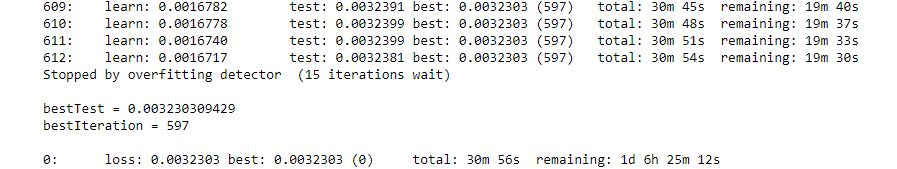

Тут просто обучение быстрое для понимания

In [9]:
%%capture
#define CatBoost model
model = cb.CatBoostRegressor(random_state=99,
                             eval_metric=custom_wape(),
                             iterations=50,
                             early_stopping_rounds=15)

#create catboost Pool object
ds = cb.Pool(X_train, label=y_train, cat_features=features_str)

#create instance of cross validation
custom_cv = CustomCrossValidation(dict_cv=data_full_cv).split()

model.fit(ds)

Learning rate set to 0.5
0:	learn: 0.8227829	total: 1.86s	remaining: 1m 31s
1:	learn: 0.5180387	total: 3.49s	remaining: 1m 23s
2:	learn: 0.2935965	total: 4.87s	remaining: 1m 16s
3:	learn: 0.2002181	total: 6.04s	remaining: 1m 9s
4:	learn: 0.1698138	total: 7.21s	remaining: 1m 4s
5:	learn: 0.1309213	total: 8.34s	remaining: 1m 1s
6:	learn: 0.1275497	total: 9.5s	remaining: 58.4s
7:	learn: 0.1253644	total: 10.6s	remaining: 55.8s
8:	learn: 0.1250254	total: 11.8s	remaining: 53.8s
9:	learn: 0.1249938	total: 13s	remaining: 51.9s
10:	learn: 0.0897787	total: 14.1s	remaining: 50.1s
11:	learn: 0.0845720	total: 15.5s	remaining: 49s
12:	learn: 0.0844899	total: 16.8s	remaining: 47.8s
13:	learn: 0.0828491	total: 18.1s	remaining: 46.5s
14:	learn: 0.0828371	total: 19.2s	remaining: 44.8s
15:	learn: 0.0828232	total: 20.4s	remaining: 43.3s
16:	learn: 0.0552903	total: 21.6s	remaining: 42s
17:	learn: 0.0552852	total: 22.8s	remaining: 40.5s
18:	learn: 0.0552733	total: 23.9s	remaining: 39s
19:	learn: 0.0533059	t

In [10]:
# cv_results = pd.DataFrame(grid_search_result["cv_results"])

# cv_results.head()

####  Проверка на тестовых данных

In [11]:
# model.get_feature_importance(train_data)

In [12]:
#тут надо переобучить на полном трейне для теста

Проверим поведение лучший модели на тестовых данных

In [13]:
# warnings.filterwarnings('ignore')

# #get test data (drop the target for correct predict with CatBoost)
# # X_test = data_full[data_full.index.isin(data_full_cv['test'])]
# # y_test = X_test['target']
# # X_test = X_test.drop(columns=['target'])

# X_test = data_submission.copy()
# y_test = X_test['target']
# X_test = X_test.drop(columns=['target'])

# #predict values
# pred = model.predict(X_test)

# #get test dates
# test_dates = data_full_dates[data_full_dates.index.isin(data_full_cv['test'])]
# test_dates['date']= pd.to_datetime(test_dates['date'], format='%Y-%m-%d')

# #add together
# X_test['date'] = test_dates
# X_test['pred'] = pred
# X_test['target'] = y_test

In [14]:
# wape(y_true=y_test, y_pred=pred)

График target VS predict

In [15]:
# pivot = pd.pivot_table(data=X_test,
#               index='date',
#               values=['target', 'pred'],
#               aggfunc='sum').sort_values(by='date')

In [16]:
# plt.figure(figsize=(12,5))
# sns.lineplot(data=pivot)

График ошибки

In [17]:
# pivot = pd.pivot_table(data=X_test,
#               index='date',
#               values=['target', 'pred'],
#               aggfunc='sum').sort_values(by='date')
# pivot['diff'] = pivot['target'] - pivot['pred']
# pivot = pivot.drop(columns=['target', 'pred'])

# plt.figure(figsize=(12,5))
# sns.lineplot(data=pivot)

Проверим поведение лучший модели на тестовых данных - выберем самый крупный магазин и самую крупную группу товаров

In [18]:
# _ = X_test[(X_test['st_id'] == 'c81e728d9d4c2f636f067f89cc14862c') & 
#        (X_test['pr_group_id'] == 'c74d97b01eae257e44aa9d5bade97baf')]

# pivot = pd.pivot_table(data=_,
#               index='date',
#               values=['target', 'pred'],
#               aggfunc='sum').sort_values(by='date')

# plt.figure(figsize=(12,5))
# sns.lineplot(data=pivot)

Формирование итогового файла с прогнозами

In [19]:
X_test = data_submission.copy()
y_test = X_test['target']
X_test = X_test.drop(columns=['target'])

pred=model.predict(X_test)

In [20]:
X_test['pred'] = pred
X_test['date'] = data_test_dates

sales_submission_ready = X_test[['st_id', 'pr_sku_id', 'date', 'pred']]

In [21]:
sales_submission_ready.to_csv('sales_submission_ready.csv', index=False)